# Adstock Campaign/Channel Attribution Model

This is a reference implementation of the adstock model that estimates the contribution of individual campaigns/channels to the total outcome (number of conversions, site traffic, etc.)

Assuming we observe activity data for several campaigns/channels as time series $x_{it}$, the total outcome is modeled as $\sum_{i} c(x_i)$ where $c(\cdot)$ is the convolution operation with the exp decay kernel.

| Description | See [Introduction to Algorithmic Marketing](https://algorithmicweb.wordpress.com/ ) book |
|--|:--|
| Dataset | Generated internally, no external dependencies |
| Libs | Numpy, Scikit-learn, statsmodels |

In [97]:
%matplotlib inline
import numpy as np
from mpmath import *
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl

In [98]:
plt.style.use('seaborn')
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothic')

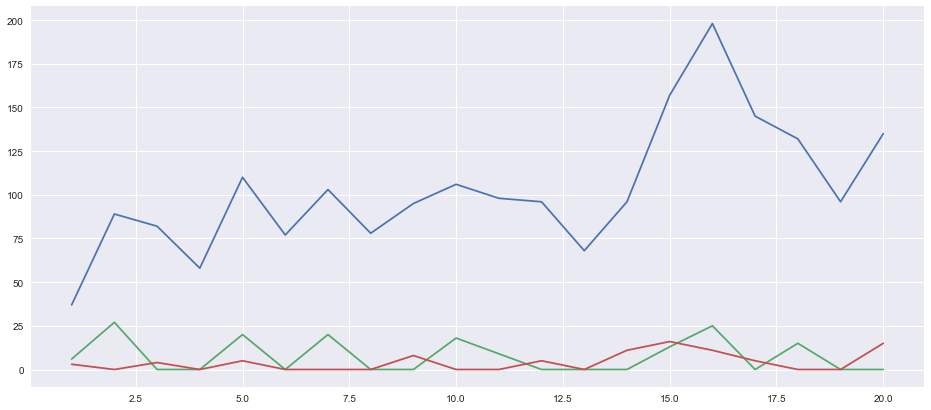

In [86]:
# The input of the model is a sequence of samples (time series) 
# where each sample is represented by three values:
#  - Total revenue
#  - Intensity of campaign 01
#  - Intensity of campaign 02
revenue_series = [37, 89, 82, 58, 110, 77, 103, 78, 95, 106, 98, 96, 68, 96, 157, 198, 145, 132, 96, 135]
campaign_series_01 = [6, 27, 0, 0, 20, 0, 20, 0, 0, 18, 9, 0, 0, 0, 13, 25, 0, 15, 0, 0]
campaign_series_02 = [3, 0, 4, 0, 5, 0, 0, 0, 8, 0, 0, 5, 0, 11, 16, 11, 5, 0, 0, 15]
decay_length = 3
time = range(1, len(revenue_series)+1)
plt.figure(figsize=(16, 7))
plt.plot(time, revenue_series, time, campaign_series_01, time, campaign_series_02);

In [62]:
#
# Apply time lag (memory effect) to the campaign intensity series
# It is modeled as a convolution operation with exp decay filter (kernel)
#

#### temp Labmda 값 적용하여 adstock y값 산출
def lag(x, alpha):
    w = np.array([ np.power(alpha, i) for i in range(decay_length) ])
    xx = np.vstack([ np.append(np.zeros(i), x[:len(x)-i]) for i in range(decay_length) ]) # lag the array
    y = np.dot(w/np.sum(w), xx)
    return y

#
# Apply the lag operation to each campaign/channel 
#

#### 개별 캠페인별 Adstock 값 산출
def adstock(x, alpha):
    return np.array([ lag(x[i], alpha[i]) for i in range(len(x)) ]).T

#### 캠페인별 Adstock으로 실제 y인 revenue에 회귀하고 loss function score 도출
def evaluate_ols_loss(x, y, alpha):
    x_transformed = adstock(x, alpha)
    reg_model = LinearRegression().fit(x_transformed, y)
    return -reg_model.score(x_transformed, y)

#
# Optimize exp decay coeffecients jointly with the linear regression model
#
#### 캠페인별 Adstock 감소 효과 산출 아래, 결과값 가장 마지막에 있는 것이 매체별 감소 효과임

y = np.array(revenue_series)
x = np.vstack([campaign_series_01, campaign_series_02])
solution = minimize(lambda alpha: evaluate_ols_loss(x, y, alpha), x0 = np.zeros(len(x)), tol=1e-6)
print(solution)

      fun: -0.8641145510062442
 hess_inv: array([[ 1.96854739, -0.56204835],
       [-0.56204835,  1.74800169]])
      jac: array([4.39584255e-07, 1.93715096e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([0.66708354, 0.65271976])


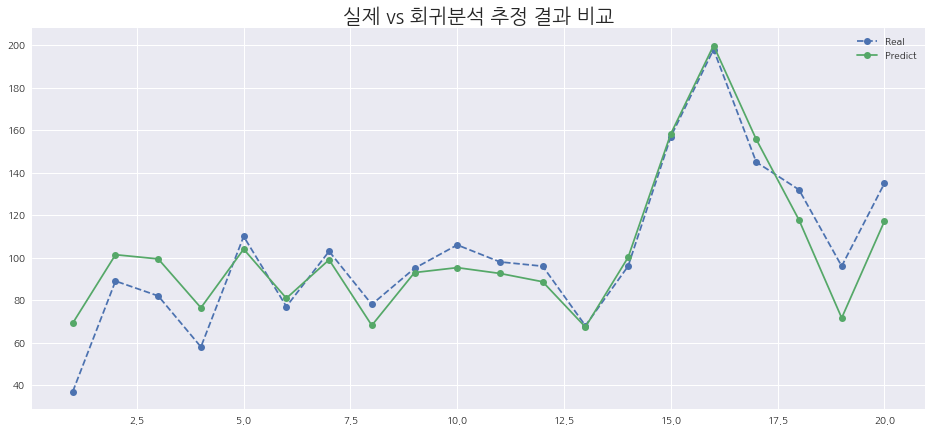

In [99]:
#
# Compare model estimation with the actual revenue series
#
x_transformed = adstock(x, solution['x'])
reg_model = LinearRegression().fit(x_transformed, y)
revenue_predicted = reg_model.predict(x_transformed)

plt.figure(figsize=(16, 7))
plt.title('실제 vs 회귀분석 추정 결과 비교', fontsize=20)
plt.plot(time, revenue_series, linestyle='--', marker='o')
plt.plot(time, revenue_predicted, marker='o')
plt.legend(['Real', 'Predict'])

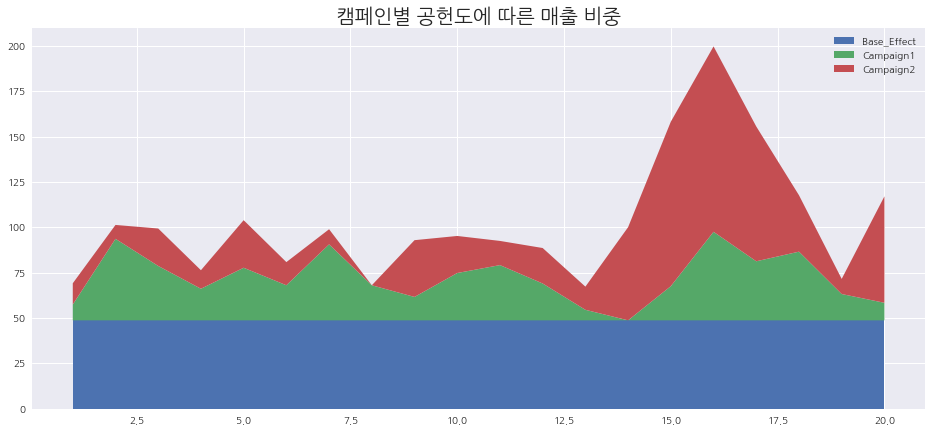

In [100]:
#
# Plot contribution for each channel on top of the intercept
#
plt.figure(figsize=(16, 7))
plt.stackplot(time, [ 
    [reg_model.intercept_]*len(time), 
    reg_model.coef_[0] * x_transformed[:, 0],
    reg_model.coef_[1] * x_transformed[:, 1]
])
plt.title('캠페인별 공헌도에 따른 매출 비중', fontsize=20)
plt.legend(['Base_Effect', 'Campaign1', 'Campaign2'])

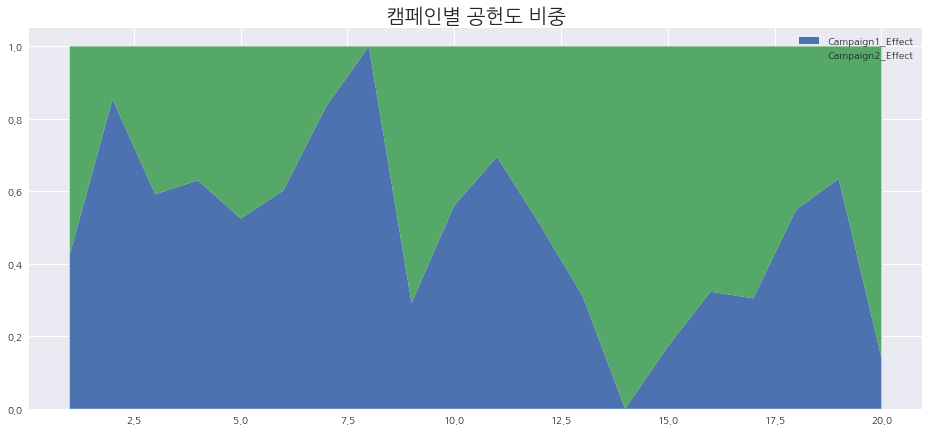

In [101]:
c1 = reg_model.coef_[0] * x_transformed[:, 0]
c2 = reg_model.coef_[1] * x_transformed[:, 1]


plt.figure(figsize=(16, 7))
plt.title('캠페인별 공헌도 비중', fontsize=20)
plt.stackplot(time, [c1/(c1+c2), 1 - c1/(c1+c2)])
plt.legend(['Campaign1_Effect', 'Campaign2_Effect'])